In [1]:
### Assigned by ###
# Gal Israeli #####
# Yulia Kuderko ###
# Ram Michaeli ####
###################

import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import random
import math
from sklearn.metrics import r2_score
import numpy as np
import sklearn.metrics as metrics


%matplotlib inline

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv("Volcano_after_cleaning.csv")
df.head()

,volcanoName,eruptionCertainty,startDate,maxVEI,evidenceMethod,stopDate,latitude,longitude,volcanoHeight,country,primaryVolcanoType,population5km,population10km,population30km,population100km
0,Ambae,1,2021 Dec 5,2,Historical Observations,2021 Dec 9,-15.389,167.835,1496,Vanuatu,Shield,73,1279,4326,73308
1,Pinatubo,1,2021 Nov 30,4,Historical Observations,2021 Nov 30,15.130,120.350,1486,Philippines,Stratovolcano,725,3808,1148684,21875048
2,Iliwerung,1,2021 Nov 28,1,Historical Observations,2021 Nov 29,-8.532,123.573,583,Indonesia,Complex,968,4318,79569,665081
3,Taal,1,2021 Nov 15,2,Historical Observations,2021 Nov 22,14.002,120.993,311,Philippines,Caldera,717090,717090,2380326,24814047
4,Turrialba,1,2021 Nov 3,2,Historical Observations,2021 Nov 23,10.025,-83.767,3340,Costa Rica,Stratovolcano,1891,6867,672428,3390544


## KNN Using Latitude and Longtiude to Predict maxVEI

In [3]:
#### KNN using latitude and longtiude , to predict maxVEI
X = df[["latitude","longitude"]]
y = df[["maxVEI"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

parameters = {'n_neighbors':range(1,int(math.sqrt(df.shape[0])),2) }
knn = KNeighborsClassifier()
model = GridSearchCV(knn, parameters,scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
model.fit(X_train, y_train)


print("Best parameter set is:",model.best_params_," and its score was",(round(model.best_score_,4)))

Best parameter set is: {'n_neighbors': 17}  and its score was 0.5996


In [4]:
userinput='y'

while(userinput=='y' or userinput=="Y"):
    lat = random.uniform(-90, 90)
    long = random.uniform(-180, 180)
    print("\nThe predicted VEI at position ("+str(round(lat,2))+","+str(round(long,2))+") is "+str(int(model.predict([[lat, long]]))))
    userinput=str(input("Try again? Y/N:  "))
print("\nDone")


The predicted VEI at position (19.1,2.76) is 2
Try again? Y/N:  y

The predicted VEI at position (65.73,95.55) is 4
Try again? Y/N:  y

The predicted VEI at position (-34.54,-133.02) is 0
Try again? Y/N:  y

The predicted VEI at position (-37.71,-171.56) is 0
Try again? Y/N:  y

The predicted VEI at position (-57.25,103.23) is 2
Try again? Y/N:  y

The predicted VEI at position (-58.53,172.12) is 4
Try again? Y/N:  y

The predicted VEI at position (4.04,135.53) is 2
Try again? Y/N:  n

Done


## Logistic Regression to Predict Eruption Strength Based on Location

In [5]:
strongEruptions = df[(df['maxVEI']>=3)]
weakEruptions = df[(df['maxVEI']<=2)]

strongEruptions['veiGroup'] = 'Strong'
weakEruptions['veiGroup'] = 'Weak'

newDF_grouped_by_maxVEI = pd.concat([weakEruptions, strongEruptions], ignore_index=True).drop(['maxVEI'], axis=1)

X = newDF_grouped_by_maxVEI[["latitude","longitude"]]
y = newDF_grouped_by_maxVEI["veiGroup"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)
scaler = MinMaxScaler(feature_range=(-1,1))
X_train_scaled = scaler.fit_transform(X_train.values)
model = sklearn.linear_model.LogisticRegression().fit(X_train_scaled, y_train.values)


scaler.fit(X_test)

for i in range(0,2):
    if i==0:
        print("First location will be (0,112) which is above Australia , right on the Ring of Fire")
        lat=0
        long = 112    
    else:
        print("\n\nSecond location will be (90,135) - Antarctica , which has volcanoes but is relatively more quiet")
        lat=90
        long = 135 
        
    position = scaler.transform([[lat, long]])
    
    weak, strong = model.predict_proba(position)[0][0], model.predict_proba(position)[0][1]
    print("\nWeak eruption probability = "+str(round(weak,4)*100)+"% \nStrong eruption probability = "+str(round(strong,4)*100)+"%\n")
    
print("\nThe results are as expected! \na location on the 'Ring of Fire' has a much higher 'Strong eruption probability'")

First location will be (0,112) which is above Australia , right on the Ring of Fire

Weak eruption probability = 20.77% 
Strong eruption probability = 79.23%



Second location will be (90,135) - Antarctica , which has volcanoes but is relatively more quiet

Weak eruption probability = 50.67% 
Strong eruption probability = 49.33%


The results are as expected! 
a location on the 'Ring of Fire' has a much higher 'Strong eruption probability'


## Predict Primary Volcano Type Based On Volcano Height

#### We will test out different algorithms and use the most successful one

In [6]:
X = df[["volcanoHeight"]]
y = df[["primaryVolcanoType"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)
print(f"Test size is: {0.3}")
print("Initial amount of samples: #{}".format(X.shape[0]))
print("Number of training samples: #{}".format(X_train.shape[0]))
print("Number of test samples: #{}".format(X_test.shape[0]))

Test size is: 0.2
Initial amount of samples: #10636
Number of training samples: #7445
Number of test samples: #3191


In [7]:
print("Classifier = 'KNN':")
parameters = {'n_neighbors':range(3,103,2) }
knn = KNeighborsClassifier()
clf = GridSearchCV(knn, parameters,scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
clf.fit(X_train, y_train)
params_KNN = list(clf.best_params_.values())[0]
print("best parameter set is:",clf.best_params_," and its score was",clf.best_score_)
print("--------------------------------------------")

print("Classifier = 'Decision Tree':")
parameters = {'max_depth':range(1,20),'min_samples_split':range(10,50,5) }
decisionTree = tree.DecisionTreeClassifier()
clf = GridSearchCV(decisionTree, parameters,scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
clf.fit(X_train, y_train)
params_DT_max_depth = list(clf.best_params_.values())[0]
params_DT_min_samples_split = list(clf.best_params_.values())[1]
print("best parameter set is:",clf.best_params_," and its score was",clf.best_score_)
print("--------------------------------------------")

print("Classifier = 'Random Forest':")
parameters = {'n_estimators':range(50,551,50) }
rf = RandomForestClassifier()
clf = GridSearchCV(rf, parameters,scoring=make_scorer(metrics.accuracy_score, greater_is_better=True))
clf.fit(X_train, y_train)
params_RF = list(clf.best_params_.values())[0]
print("best parameter set is:",clf.best_params_," and its score was",clf.best_score_)
print("--------------------------------------------")

Classifier = 'KNN':
best parameter set is: {'n_neighbors': 3}  and its score was 0.9509738079247818
--------------------------------------------
Classifier = 'Decision Tree':
best parameter set is: {'max_depth': 19, 'min_samples_split': 10}  and its score was 0.9466756212222969
--------------------------------------------
Classifier = 'Random Forest':
best parameter set is: {'n_estimators': 400}  and its score was 0.9642713230355945
--------------------------------------------


In [8]:
clf1 = KNeighborsClassifier(n_neighbors=params_KNN)
clf2 = tree.DecisionTreeClassifier(max_depth= params_DT_max_depth, min_samples_split= params_DT_min_samples_split)
clf3 = RandomForestClassifier(n_estimators=params_RF,bootstrap=True)
clf4 = GaussianNB()
algNames=["KNN", "Decision Tree", "Random Forest", "Naive Bayes"]
bestCLF = None
bestACC = 0
for i,clf in enumerate([clf1,clf2,clf3,clf4]):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
    print(algNames[i])
    currentACC = metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train)
    print('Accuracy on training data = ', metrics.accuracy_score(y_true = y_train, y_pred = y_pred_train))
    print('Accuracy on test data = ', metrics.accuracy_score(y_true = y_test, y_pred = y_pred))
    print("--------------------------------------------")
    if currentACC > bestACC:
        bestACC = currentACC
        bestCLF=clf
print("The best CLF is: "+str(bestCLF))

KNN
Accuracy on training data =  0.9645399597044997
Accuracy on test data =  0.9526794108429959
--------------------------------------------
Decision Tree
Accuracy on training data =  0.955137676292814
Accuracy on test data =  0.9460984017549358
--------------------------------------------
Random Forest
Accuracy on training data =  0.9759570181329752
Accuracy on test data =  0.9636477593230962
--------------------------------------------
Naive Bayes
Accuracy on training data =  0.642578912021491
Accuracy on test data =  0.637731118771545
--------------------------------------------
The best CLF is: RandomForestClassifier(n_estimators=400)


In [11]:
userinput='y'
num=int(input("Enter volcano height: "))
while(userinput=='y' or userinput=="Y"):
    if num<-4200 or num>6879:
        print("\nPlease enter values between -4200 and 6879")
        num=int(input("Enter volcano height: "))
        continue
    print("The predicted primary volcano type is: "+str(bestCLF.predict([[num]])))
    userinput=str(input("Try again? Y/N:  "))
    if not(userinput=='y' or userinput=="Y"):
        print("\nDone")
        break
    num=int(input("Enter volcano height: "))

Enter volcano height: -2500
The predicted primary volcano type is: ['Submarine']
Try again? Y/N:  y
Enter volcano height: 1500
The predicted primary volcano type is: ['Shield']
Try again? Y/N:  y
Enter volcano height: 3500
The predicted primary volcano type is: ['Volcanic field']
Try again? Y/N:  n

Done


## Using Linear Regression to Predict S02 Emissions Based on Volcano Height

In [12]:
df_emission = pd.read_csv("Volcano_Emission.csv")

df_emission.sort_values("SO2_Altitude")

names = list(df_emission.volcanoName.value_counts().keys())

df_emission[df_emission['volcanoName']=='Etna'].SO2_Altitude.mean()

combined = pd.DataFrame()
SO2_Mass_kt_AVG = list()
SO2_Altitude_AVG = list()
for name in names:
    SO2_Mass_kt_AVG.append(df_emission[df_emission['volcanoName']==name].SO2_Mass_kt.mean())
    SO2_Altitude_AVG.append(df_emission[df_emission['volcanoName']==name].SO2_Altitude.mean())
data= \
    {
        'names':names,
        'SO2_Mass_kt_AVG':SO2_Mass_kt_AVG,
        "SO2_Altitude_AVG":SO2_Altitude_AVG
    }
combined = pd.DataFrame.from_dict(data)


for i,j in df.iterrows():
    if j['volcanoName'] not in names:
        df.drop(i,inplace=True)
        
df['SO2_Mass_kt_AVG'] = None
df['SO2_Altitude_AVG'] = None

for i in range(0,df.shape[0]):
    df['SO2_Altitude_AVG'].iloc[i] = float(combined.loc[combined['names']==df['volcanoName'].iloc[i]]['SO2_Altitude_AVG'])
    df['SO2_Mass_kt_AVG'].iloc[i] = float(combined.loc[combined['names']==df['volcanoName'].iloc[i]]['SO2_Mass_kt_AVG'])

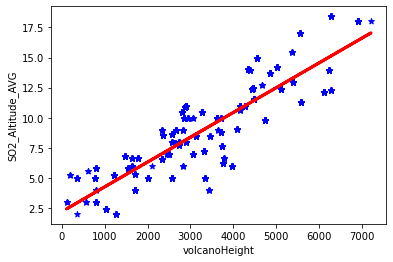

Linear model score : 70.36%


In [43]:
m=linear_model.LinearRegression().fit(df[['volcanoHeight']],df[['SO2_Altitude_AVG']])

plt.scatter(x=df['volcanoHeight'],y=df['SO2_Altitude_AVG'],c='b',marker='*',label='Height')
plt.plot(df['volcanoHeight'],m.predict(df[['volcanoHeight']]),color='red',linewidth=3)
plt.xlabel('volcanoHeight')
plt.ylabel('SO2_Altitude_AVG')
plt.show()

myscore = r2_score(df.SO2_Altitude_AVG.tolist(),m.predict(df[['volcanoHeight']]).flatten())

print("Linear model score : "+str(round(myscore*100,2))+"%")

In [45]:
X = df[['volcanoHeight']]
y = df.SO2_Altitude_AVG
XTrain, XTest, yTrain, yTest = train_test_split(X.values, y.astype('int'), test_size=0.2)
model = sklearn.linear_model.LinearRegression().fit(XTrain, yTrain)
y_pred=model.predict(XTest)

print("The model score is: "+str(model.score(X,y)))

The model score is: 0.6960216147835554


In [46]:
userinput='y'
num=int(input("Enter volcano height: "))
while(userinput=='y' or userinput=="Y"):
    if num<-4200 or num>6879:
        print("\nPlease enter values between -4200 and 6879")
        num=int(input("Enter volcano height: "))
        continue
    print("The predicted SO2_Altitude_AVG is: "+str(float(clf.predict([[num]]))))
    userinput=str(input("Try again? Y/N:  "))
    if not(userinput=='y' or userinput=="Y"):
        print("\nDone")
        break
    num=int(input("Enter volcano height: "))

Enter volcano height: 700
The predicted SO2_Altitude_AVG is: 5.0
Try again? Y/N:  y
Enter volcano height: 2400
The predicted SO2_Altitude_AVG is: 8.0
Try again? Y/N:  y
Enter volcano height: 5600
The predicted SO2_Altitude_AVG is: 11.0
Try again? Y/N:  n

Done
